In [19]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

import hashlib

def get_hash(num):
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which you will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included `codebook.txt` file (you can optionally open this by first clicking the `data` folder, then clicking `codebook.txt` file in the navigation pane). 

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

In [20]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

In [21]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [22]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [23]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [24]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: Exploratory Data Analysis

In [25]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

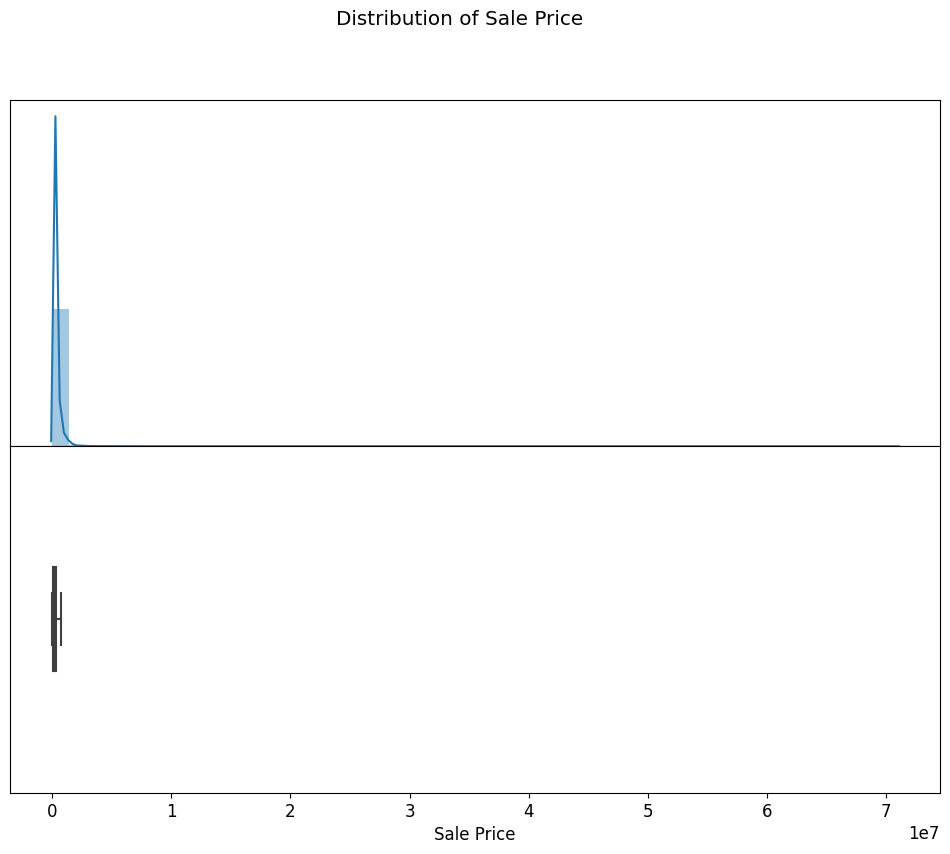

In [26]:
plot_distribution(training_data, label='Sale Price')

In [27]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

<!-- END QUESTION -->



In [28]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

Let's create a new distribution plot on the log-transformed sale price.

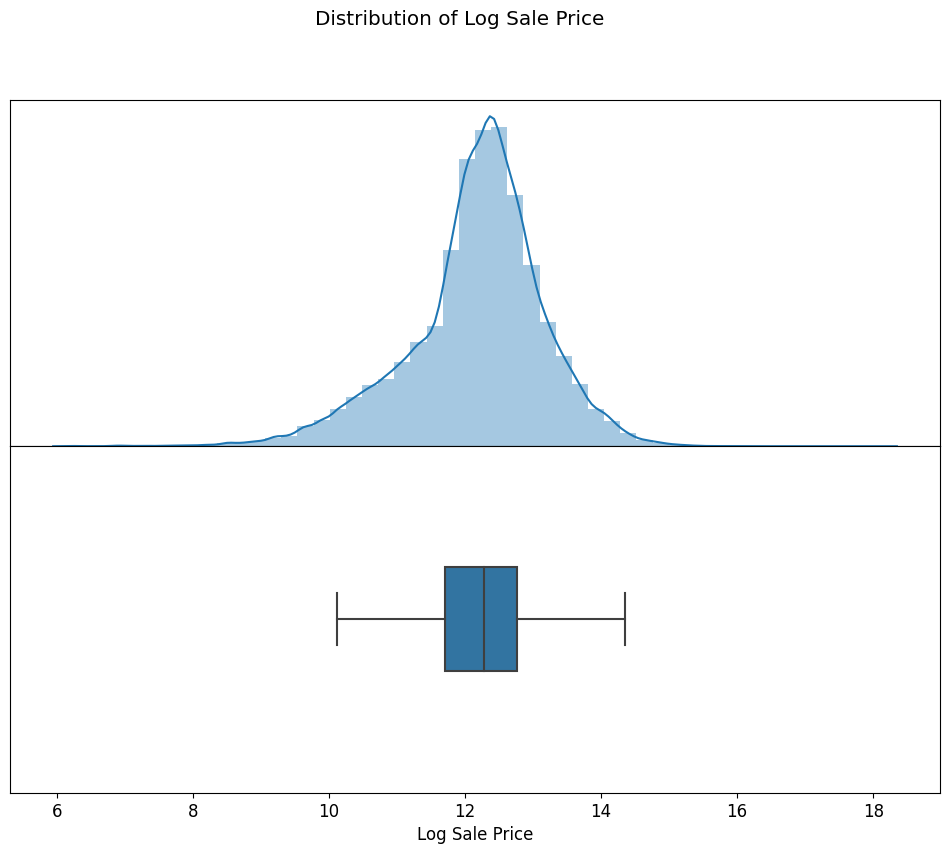

In [29]:
plot_distribution(training_data, label='Log Sale Price');

In [30]:
len(training_data[training_data['Sale Price'] > 200000]) / len(training_data)

0.5328270122120866

In [31]:
# These should be True or False
q3statement = True


In [32]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

In [33]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  

    return data[(data[variable] > lower) & (data[variable] <= upper)]


In [34]:
removed_outliers = remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

Extracting the number of bedrooms from the description

In [35]:
# optional cell for scratch work 
for i in range(10):
    print(training_data['Description'].iloc[i])


This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.
This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 10/26/2017, is a one-story with partially livable attics houeshold located at 2820 186TH ST.It has a total of 6 rooms, 4 of which are bedrooms, and 1.5 of which are bathrooms.
This property, sold on 08/30/2016, is a two-story houeshold located at 3034 PALM LN.I

In [36]:
q5a = [1, 2, 4, 6, 7, 8]

In [37]:
# Print out Description column and notice where/how bathrooms are saved:
print(training_data["Description"][1])
print("")
print(training_data["Description"][60])

This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.

This property, sold on 10/11/2016, is a two-story houeshold located at 123 S LANCASTER AVE.It has a total of 9 rooms, 4 of which are bedrooms, and 2.5 of which are bathrooms.


In [38]:
# Copy the first 10 rows to use as an example set
example_df = training_data[["Description"]][:10].copy()

# Create a Regex with the format of the bathroom information
bathrooms_regex = r'and (\d+\.\d) of which are bathrooms.'

# Extract the bathroom information from the "Description" column
example_output = example_df["Description"].str.extract(bathrooms_regex).astype(float)

example_output



,0
1,1.0
2,1.0
3,1.5
4,1.0
6,1.5
7,2.5
8,2.0
9,1.5
10,1.0
11,1.0


In [39]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r'(\d+) of which are bedrooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(float)
    
    with_rooms['Bedrooms'] = rooms
    
    return with_rooms

training_data = add_total_bedrooms(training_data)

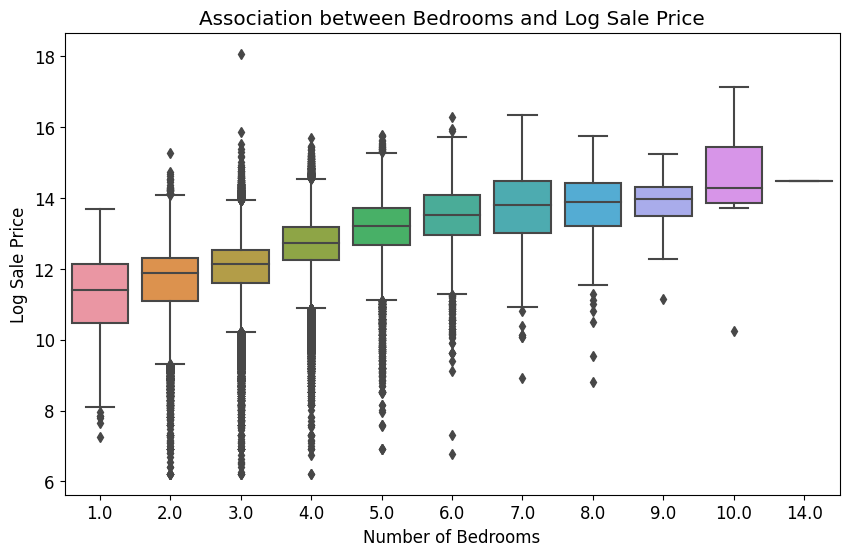

In [40]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='Bedrooms', y='Log Sale Price', data=training_data)
plt.title('Association between Bedrooms and Log Sale Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Log Sale Price')
plt.show()


In [41]:
num_neighborhoods = training_data['Neighborhood Code'].nunique()
num_neighborhoods

193

In [42]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [43]:
top_20_neighborhood_codes = training_data['Neighborhood Code'].value_counts().index[:20]
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_neighborhood_codes)]


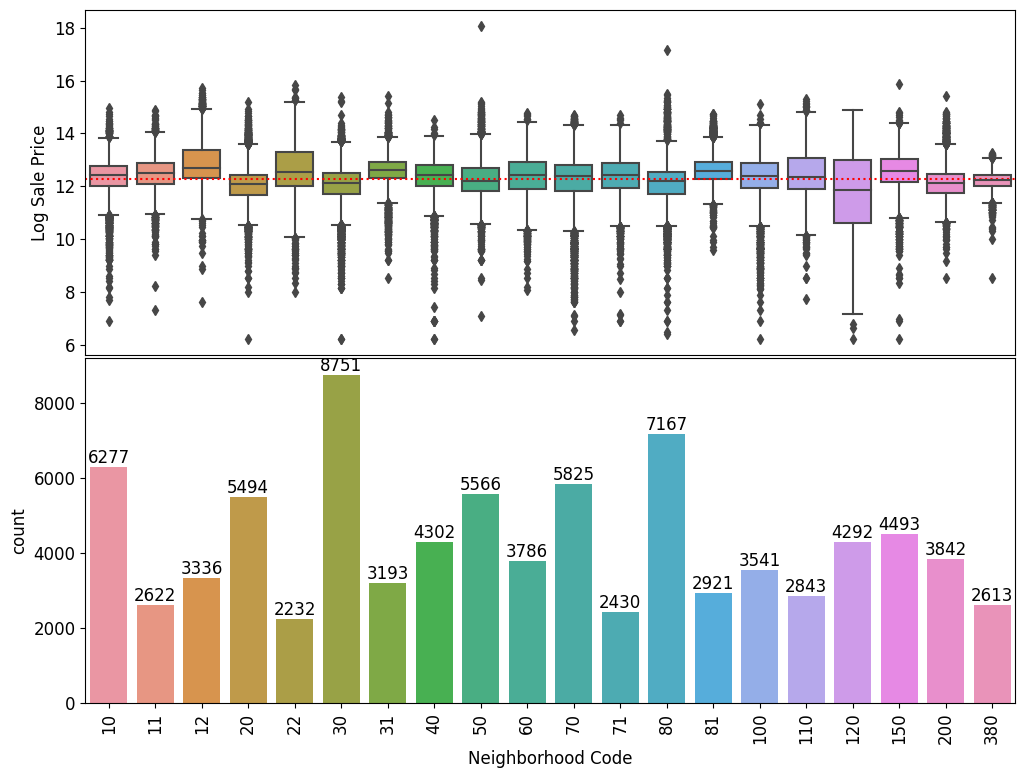

In [44]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

In [45]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code')['Log Sale Price'].apply(metric).sort_values(ascending=False).head(n).index.tolist()
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

In [46]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

training_data.head()

len(training_data[training_data["in_expensive_neighborhood"]==1])

1290

In [47]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    copy_data = data.copy()
    roof_material_mapping = {
        1: 'Shingle/Asphalt',
        2: 'Tar&Gravel',
        3: 'Slate',
        4: 'Shake',
        5: 'Tile',
        6: 'Other'
    }
    copy_data['Roof Material'] = copy_data['Roof Material'].replace(roof_material_mapping)
    return copy_data
    
training_data = substitute_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3.0,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3.0,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3.0,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2.0,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4.0,0


In [48]:
# Sample code to demonstrate One Hot Encoding

from sklearn.preprocessing import OneHotEncoder

oh_enc = OneHotEncoder()
oh_enc.fit([['Anirudhan'], ['Dominic'], ['Rahul'], ['Rahul'], ['Anirudhan'], ['Yike'], ['Vasanth']]);
oh_enc.transform([['Anirudhan'], ['Rahul'], ['Dominic']]).toarray()


array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [49]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form "Roof Material_MATERIAL"
    """
    data = data.copy()
    ohe = OneHotEncoder()

    ohe.fit(data[['Roof Material']])
    
    ohe_data = ohe.transform(data[['Roof Material']]).toarray()
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(['Roof Material']))

    data_reset = data.reset_index(drop=True)
    ohe_df_reset = ohe_df.reset_index(drop=True)
    
    return pd.concat([data_reset, ohe_df_reset], axis=1)
    
training_data_ohe = ohe_roof_material(training_data)
#This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(5)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
